In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
train_data = kgs.load_all_train_data()
data = np.stack([d.spectrum for d in train_data]).T
wavelengths = kgs.wavelengths
#data = data[:,1:].T
#data.shape, wavelengths.shape

local


Text(0, 0.5, 'Transit depth')

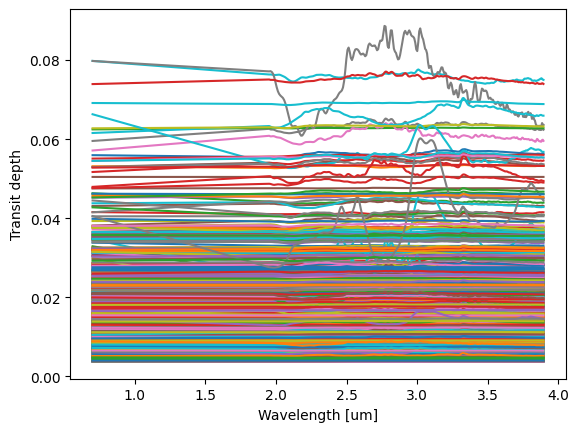

In [2]:
plt.figure()
plt.plot(wavelengths, data);
plt.xlabel('Wavelength [um]')
plt.ylabel('Transit depth')

Text(0, 0.5, 'Transit depth (mean removed)')

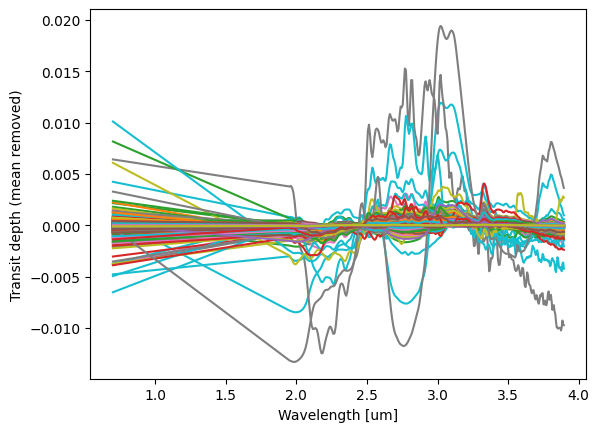

In [3]:
plt.figure()
plt.plot(wavelengths, data-np.mean(data,0));
plt.xlabel('Wavelength [um]')
plt.ylabel('Transit depth (mean removed)')

1.0


Text(0, 0.5, 'Transit depth (mean removed, normalized)')

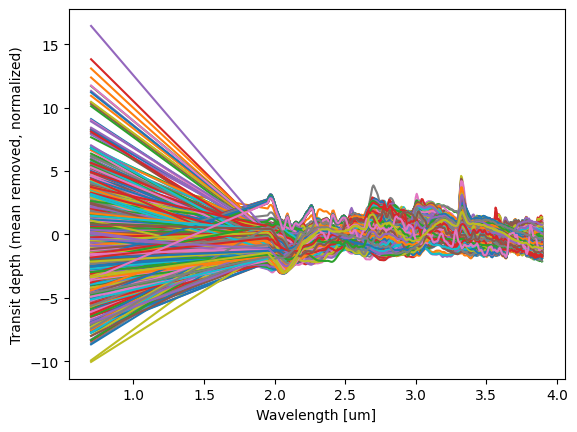

In [4]:
high_std = np.std(data,0)>0
print(np.sum(high_std)/len(high_std))
this_data = data[:,high_std]
data_norm = (this_data-np.mean(this_data,0))/np.std(this_data,0)
plt.figure()
plt.plot(wavelengths, data_norm);
plt.xlabel('Wavelength [um]')
plt.ylabel('Transit depth (mean removed, normalized)')

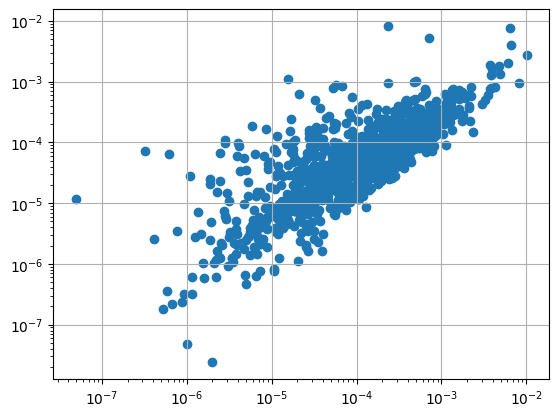

In [5]:
plt.figure()
data_mean_corrected = data-np.mean(data,0)
plt.scatter(np.abs(data_mean_corrected[0,:]), np.std(data_mean_corrected[1:,:],0))
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.grid(True)

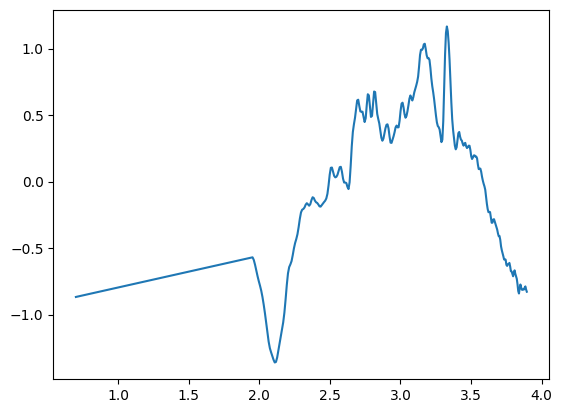

In [6]:
plt.figure()
plt.plot(wavelengths, np.mean(data_norm,1))

Text(0, 0.5, 'Std of transit depth')

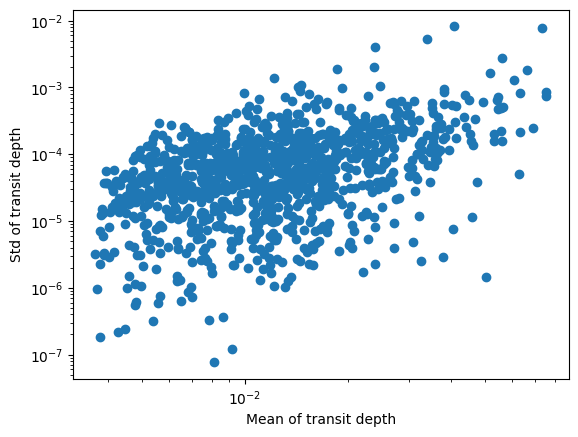

In [7]:
plt.figure()
plt.scatter(np.mean(data,0), np.std(data,0))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean of transit depth')
plt.ylabel('Std of transit depth')

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Treat columns of `data` as samples (like your original `.T` did)
# X shape: (n_samples, n_features)
X = (data-np.mean(data,0)).T  # NO CENTERING
#X = ((this_data-np.mean(this_data,0))/np.std(this_data,0)).T

for iii in range(20):
    # SVD: X = U @ np.diag(S) @ Vh
    U, S, Vh = np.linalg.svd(X, full_matrices=False)

    # Principal directions in feature space (rows = PCs)
    components = Vh                              # shape: (n_components, n_features)

    # Weights / scores of each sample on each PC
    weights = U * S                              # shape: (n_samples, n_components)

    # Explained variance (uncentered): eigenvalues of X^T X scaled like sklearn
    n_samples = X.shape[0]
    den = max(n_samples - 1, 1)                  # avoid /0 if there's only 1 sample
    explained_variance = (S**2) / den            # per-component variance (like sklearn's PCA.explained_variance_)
    explained_variance_ratio = (S**2) / np.sum(S**2)

    # Your plots
    #plt.figure()
    #plt.plot(wavelengths, components[:5, :].T)   # first 5 PCs as spectra vs wavelength

   # plt.figure()
    #plt.plot(1 - np.cumsum(explained_variance_ratio)[:20])  # leftover variance (like your original)
   # plt.plot(explained_variance_ratio[:20])
   # plt.pause(0.001)
    #(1 - np.cumsum(explained_variance_ratio)[:20])[0]
    #kgs.rms(X),kgs.rms(X-weights@components)

    # Rescale weights such that nobody gets more than 10% of the signal
    for ii in range(len(wavelengths)):
        if explained_variance_ratio[ii]>0.2:
            weights[:,ii] *= (0.2/explained_variance_ratio[ii])**2

    X = weights@components
data_rescaled = X.T

Text(0, 0.5, 'Transit depth (mean removed, normalized)')

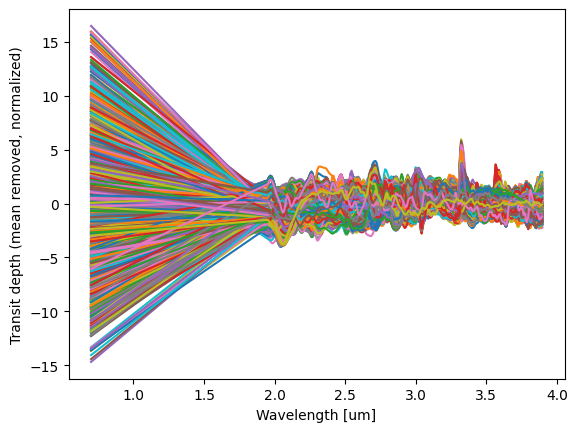

In [24]:
this_data = data_rescaled
data_norm = (this_data-np.mean(this_data,0))/np.std(this_data,0)
plt.figure()
plt.plot(wavelengths, data_norm);
plt.xlabel('Wavelength [um]')
plt.ylabel('Transit depth (mean removed, normalized)')

In [25]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import UnivariateSpline
from numpy.linalg import eigh
import scipy

def empirical_cov(Y):
    # Y: (N,M), rows = sample paths, cols = points
    Yc = Y - Y.mean(axis=0, keepdims=True)
    return (Yc.T @ Yc) / (Y.shape[0] - 1)

def bin_by_distance(x, K, nbins=50, min_per_bin=20):
    x = np.asarray(x).ravel()
    D = squareform(pdist(x[:,None], 'euclidean'))  # (M,M)
    r = D[np.triu_indices_from(D)]
    v = K[np.triu_indices_from(K)]
    # bin edges from 0 to max distance
    edges = np.linspace(0, r.max() + 1e-12, nbins+1)
    centers, means = [], []
    for a,b in zip(edges[:-1], edges[1:]):
        mask = (r >= a) & (r < b)
        if mask.sum() >= min_per_bin:
            centers.append(0.5*(a+b))
            means.append(v[mask].mean())
    return np.array(centers), np.array(means)

def smooth_kernel(r, k_r, s=None):
    # s: smoothing factor (None lets spline choose ~ good default)
    # Enforce evenness & k'(0)=0 by mirroring
    r_full = np.concatenate([-r[::-1], r])
    k_full = np.concatenate([k_r[::-1], k_r])
    #spl = UnivariateSpline(r_full, k_full, s=s)
    spl = scipy.interpolate.interp1d(r_full, k_full, fill_value='extrapolate')
    plt.figure()
    plt.plot(r_full,k_full)
    plt.title('Input to spline')
    def kfun(h):
        h = np.abs(np.asarray(h))
        return spl(h)
    return kfun

def nearest_psd(A, eps=1e-12):
    # Higham-like eigenvalue clipping
    w, V = eigh((A + A.T)/2)
    w = np.clip(w, eps, None)
    return (V * w) @ V.T

# Example parametric kernels
def k_rbf(r, amp, ell): return amp**2 * np.exp(-0.5*(r/ell)**2)
def k_matern32(r, amp, ell): 
    z = np.sqrt(3)*r/ell
    return amp**2 * (1+z)*np.exp(-z)

def fit_parametric_from_cov(x, K_emp, family='matern32', nugget=True):
    from scipy.optimize import minimize

    D = squareform(pdist(x[:,None], 'euclidean'))
    def K_theta(theta):
        amp = np.exp(theta[0]); ell = np.exp(theta[1])
        if family == 'rbf':
            K = k_rbf(D, amp, ell)
        else:
            K = k_matern32(D, amp, ell)
        if nugget:
            sn2 = np.exp(theta[2])
            K = K + sn2*np.eye(len(x))
        return K

    # init guesses from data scale
    amp0 = np.sqrt(np.median(np.diag(K_emp)))
    ell0 = (x.max()-x.min())/5
    th0 = [np.log(max(amp0,1e-6)), np.log(max(ell0,1e-6))]
    if nugget:
        sn20 = max(1e-6, 0.01*np.median(np.diag(K_emp)))
        th0.append(np.log(sn20))

    def obj(theta):
        Kt = K_theta(theta)
        R = K_emp - Kt
        return np.sum(R*R)  # Frobenius norm squared

    res = minimize(obj, np.array(th0), method='L-BFGS-B')
    return res

def estimate_kernel(x, Y, nbins=50, min_per_bin=20, smooth_s=None, enforce_psd=True):
    # Empirical covariance
    K_emp = empirical_cov(Y)
    plt.figure()
    plt.imshow(K_emp)
    plt.colorbar()

    # Nonparametric kernel estimate (bin + smooth)
    r, k_r = bin_by_distance(x, K_emp, nbins=nbins, min_per_bin=min_per_bin)
    plt.figure()
    plt.plot(r,k_r)
    kfun = smooth_kernel(r, k_r, s=smooth_s)
    plt.figure()
    plt.plot(r,kfun(r))

    # Build covariance from kfun on grid
    D = squareform(pdist(np.asarray(x)[:,None], 'euclidean'))
    K_np = kfun(D)

    if enforce_psd:
        K_np = nearest_psd(K_np)

    return K_np, kfun, K_emp

Fitted params (log): [ -9.19037579  -0.94506305 -13.81551056]


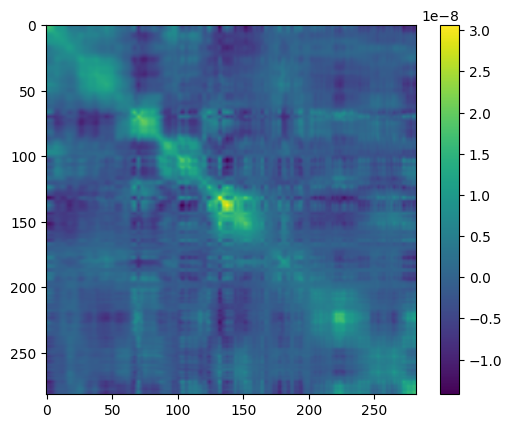

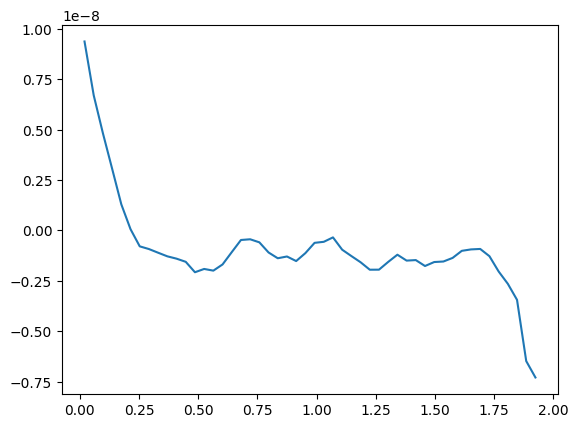

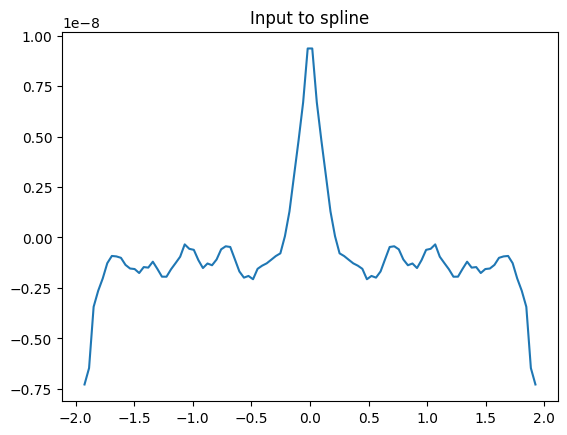

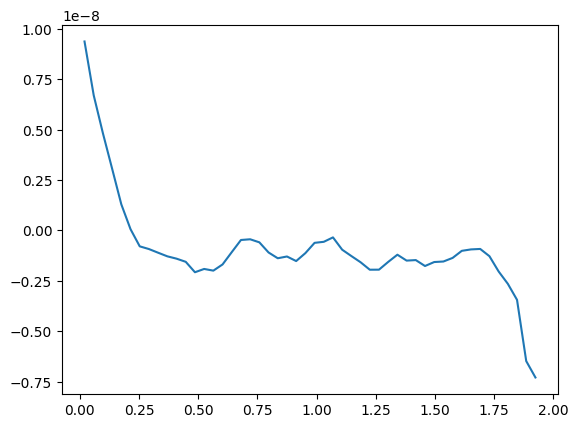

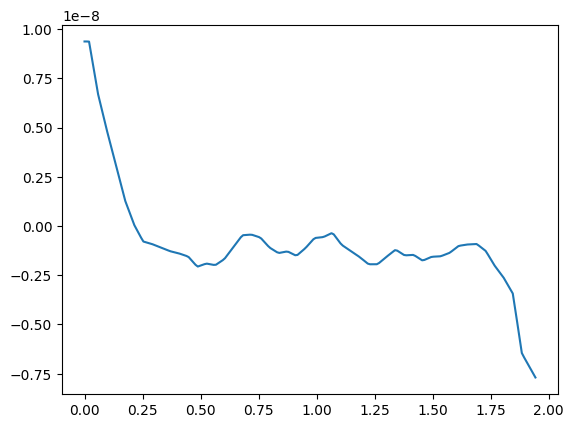

In [31]:
#from sklearn.decomposition import PCA import numpy as np
# x=kgs.wavelengths[1:]
# dat = data_norm
# Y=(dat-np.mean(dat,0)).T
# Y=Y-np.mean(Y,1)[:,None]

# pca = PCA(n_components=5)
# pca.fit(Y.T)
# components = pca.components_          # Principal directions (eigenvectors)
# explained_variance = 1-np.cumsum(pca.explained_variance_ratio_)  # Variance explained by each PC

# plt.figure()
# plt.plot(explained_variance)

# ii=2
# scores = pca.transform(Y.T)[:, :ii]             # (n_samples, ii)
# recon = scores @ pca.components_[:ii, :]      # (n_samples, 64)
# recon += pca.mean_    

x= wavelengths[1:]
Y = data_rescaled[1:,:].T

# x: shape (M,), Y: shape (N,M)
K_np, kfun, K_emp = estimate_kernel(x, Y)

# Evaluate kernel at any lag r>=0:
r_test = np.linspace(0, (x.max()-x.min()), 200)
k_vals = kfun(r_test)

plt.figure()
plt.plot(r_test,k_vals)

# # (Optional) fit a parametric kernel to the empirical covariance:
res = fit_parametric_from_cov(x, K_emp, family='matern32', nugget=True)
print("Fitted params (log):", res.x)

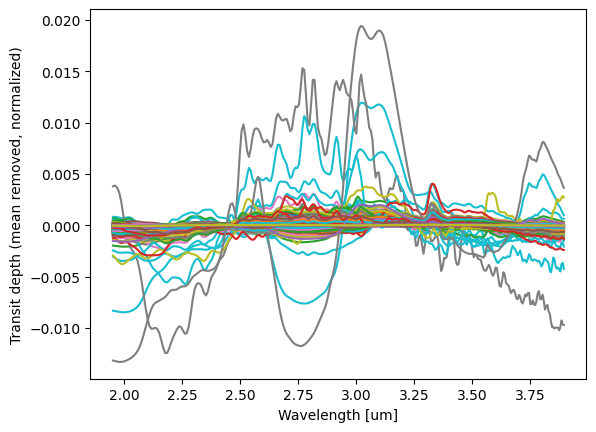

kernel_types=['old_dynamic'], x_forms=['id'], dep_sigma=[False]
[1.00000000e-06 1.00000000e+00 2.11494030e-05 3.02852084e-05
 2.24730515e-05 5.08790004e-04 1.58072952e-05 1.01751653e-04
 5.76075125e-05 4.42099787e-05 1.02367768e-05] 2837444.9170793425 2837444.9170793425


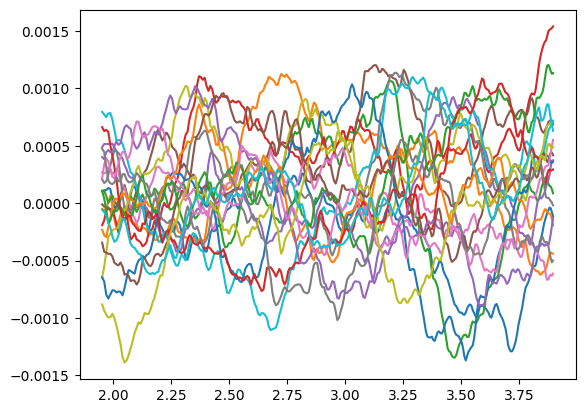

kernel_types=['matern52', 'SE'], x_forms=['id', 'id'], dep_sigma=[False, False]
[3.15263771e-06 4.05559182e-04 9.75040506e-02 4.29286422e-05
 9.64488663e-03] 2829238.542733214 2829238.542733214


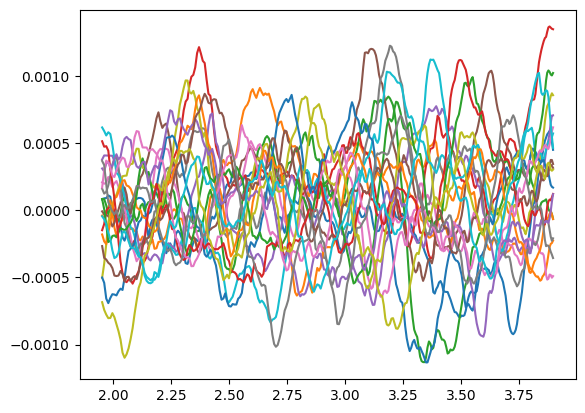

kernel_types=['matern52', 'SE'], x_forms=['id', 'gamma'], dep_sigma=[False, False]
[1.00000000e-06 4.77147429e-04 1.85144473e-01 2.86785035e+00
 7.73649502e-05 2.93954121e-01] 3028174.2362240944 3028174.2362240944


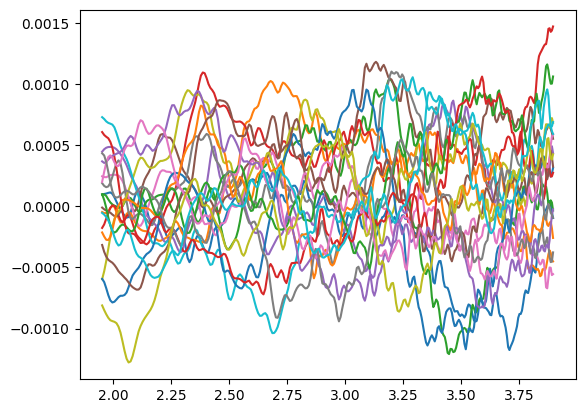

kernel_types=['matern52', 'SE'], x_forms=['gamma', 'gamma'], dep_sigma=[False, False]
[1.00000000e-06 1.00000655e+00 4.77165978e-04 1.85140486e-01
 2.86781175e+00 7.73693176e-05 2.93946980e-01] 3028174.238255839 3028174.238255839


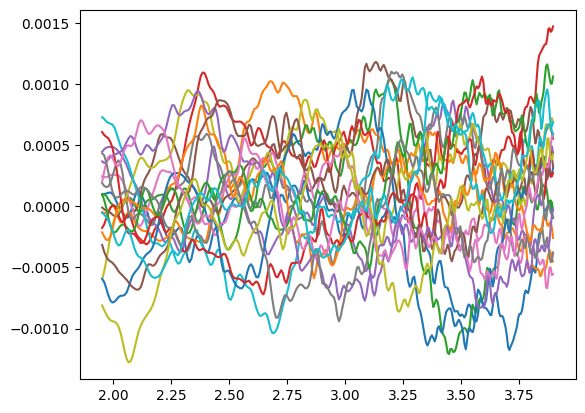

kernel_types=['SE', 'SE'], x_forms=['id', 'id'], dep_sigma=[False, False]
[3.44192522e-06 3.80028612e-04 6.27510286e-02 5.04334641e-05
 1.01585148e-02] 2819354.7678690525 2819354.7678690525


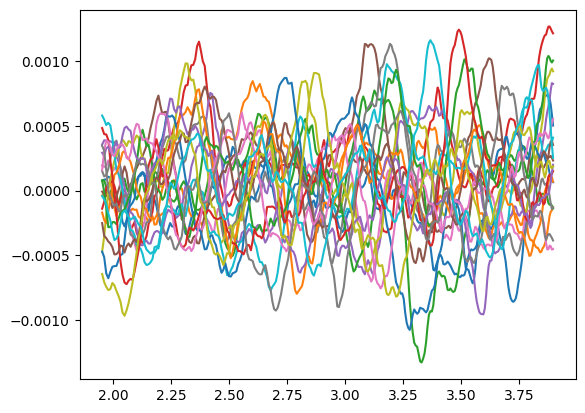

kernel_types=['SE', 'SE'], x_forms=['id', 'gamma'], dep_sigma=[False, False]
[1.00000000e-06 4.15761650e-04 1.14799559e-01 2.83765745e+00
 8.12033204e-05 2.82646887e-01] 3026532.447249715 3026532.447249715


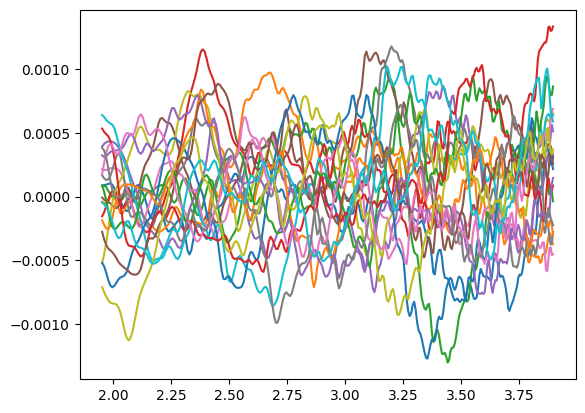

kernel_types=['SE', 'SE'], x_forms=['gamma', 'gamma'], dep_sigma=[False, False]
[1.00000000e-06 1.00000889e+00 4.15741356e-04 1.14796647e-01
 2.83765873e+00 8.12004302e-05 2.82637656e-01] 3026532.448649797 3026532.448649797


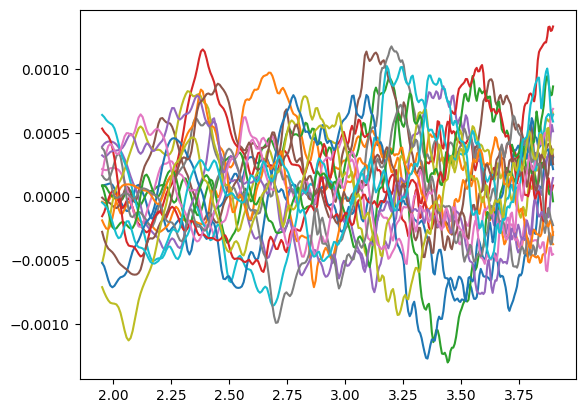

In [318]:
import cupy as cp
import scipy as sp
import copy
this_data = data[1:,:]
data_norm = cp.array ((this_data-np.mean(this_data,0))/np.std(this_data)*np.std(data[1:,:]))
plt.figure()
plt.plot(wavelengths[1:], data_norm.get());
plt.xlabel('Wavelength [um]')
plt.ylabel('Transit depth (mean removed, normalized)')
plt.pause(0.001)
# plt.figure()
# plt.plot(1/wavelengths[1:], data_norm.get());
# plt.xlabel('Wavelength [um]')
# plt.ylabel('Transit depth (mean removed, normalized)')
x = cp.array(wavelengths[1:])

#include_damping, model_k, single/double

def K_matrix(hyperparameters):
    #hyperparameters = copy.deepcopy(hyperparameters)
    try: hyperparameters = hyperparameters.get()
    except: pass
    cur_ind = 0
    
    # noise
    K = hyperparameters[cur_ind]**2*cp.eye(x.shape[0])
    #K = 1e-6**2*cp.eye(x.shape[0])
    cur_ind+=1
    
    for i_kernel in range(len(kernel_types)):        
        xx = x[:,None]
        if x_forms[i_kernel] == 'id':
            this_x = xx
        elif x_forms[i_kernel] == 'gamma':
           # print('gamma', hyperparameters[cur_ind], cur_ind)
            this_x = xx**hyperparameters[cur_ind]
            cur_ind+=1
        elif x_forms[i_kernel] == 'log':
            this_x = cp.log(xx)
        else:
            raise 'stop'
            
        sigma = hyperparameters[cur_ind]
        cur_ind+=1
        
        if not dep_sigma[i_kernel]:
            sigma_mat = sigma**2
        else:
            slope = hyperparameters[cur_ind]
            cur_ind+=1
            sigma = sigma + slope*(xx-cp.max(xx))
            #plt.figure()
            #plt.plot(sigma.get())
            sigma_mat = sigma * sigma.T
        
        
        if kernel_types[i_kernel] == 'SE':     
            ell = hyperparameters[cur_ind]
            cur_ind+=1
            K += sigma_mat * cp.exp(-(this_x - this_x.T)**2 / (2 * ell**2))
        elif kernel_types[i_kernel] == 'matern12':
            ell = hyperparameters[cur_ind]
            cur_ind+=1
            K += sigma_mat * cp.exp(-cp.abs(this_x - this_x.T) / ell)
        elif kernel_types[i_kernel] == 'matern32':
            ell = hyperparameters[cur_ind]
            cur_ind+=1
            r = cp.abs(this_x - this_x.T) / ell
            a = cp.sqrt(3.0) * r
            K += sigma_mat * (1.0 + a) * cp.exp(-a)
        elif kernel_types[i_kernel] == 'matern52':
            ell = hyperparameters[cur_ind]
            cur_ind+=1
            r = cp.abs(this_x - this_x.T) / ell
            a = cp.sqrt(5.0) * r
            K += sigma_mat * (1.0 + a + (5.0 / 3.0) * r**2) * cp.exp(-a)
        elif kernel_types[i_kernel] == 'old_fixed':
            K = sigma_mat*cp.array(get_K_mm(mm, mm.sigmas, this_x.get()))
        elif kernel_types[i_kernel] == 'old_dynamic':
            mmm = copy.deepcopy(mm)
            mmm.sigmas[:-1] = hyperparameters[cur_ind:cur_ind+9]
            cur_ind+=9
            K = cp.array(get_K_mm(mmm, mmm.sigmas, this_x.get()))
        else:
            raise['stop']
    
    assert cur_ind == len(hyperparameters)
    return K
    # def kernel(hyp_part):
    #     sigma = hyp_part[0]
    #     if kernel_form=='noise':
    #         return sigma**2*cp.eye(this_x.shape[0])
    #     elif kernel_form=='SE':            
    #         ell = hyp_part[1]
    #         noise = hyp_part[2]
    #         return sigma**2*cp.exp(-(this_x-this_x.T)**2/(2*ell**2) ) + noise**2 *cp.eye(this_x.shape[0])      
    # if model_k:
    #     this_x = x**hyperparameters[-1]#cp.mean(x)**2/x
    #     hyperparameters = hyperparameters[:-1]
    # else:
    #     this_x = x
    # this_x = this_x[:,None]    
    # assert not cosine_damping
    # if single:
    #     return kernel(hyperparameters)
    # else:
    #     K1 = kernel(hyperparameters[:len(hyperparameters)//2])
    #     K2 = kernel(hyperparameters[len(hyperparameters)//2:])           
    #     return K1+K2
    
def log_likelihood(hyperparameters, data):    
    K = K_matrix(hyperparameters)
    assert not(cp.any(cp.isnan(K)))
    N, M = data.shape

    # Cholesky decomposition (better numerics than slogdet/inv)
    L = cp.linalg.cholesky(K)  # K = L L^T
    # plt.figure()
    # plt.imshow(K.get())
    # plt.figure()
    # plt.imshow((L@L.T).get())
    # raise('stop')
    assert not(cp.any(cp.isnan(L)))

    # log|K| = 2 * sum(log(diag(L)))
    logdetK = 2.0 * cp.sum(cp.log(cp.diag(L)))

    # Solve K^{-1} Y efficiently via triangular solves
    alpha = cp.linalg.solve(L, data)        # solve L α = Y
    alpha = cp.linalg.solve(L.T, alpha)     # α = K^{-1} Y

    # quadratic term = sum over columns of Y^T K^{-1} Y
    quad = cp.sum(data * alpha)

    loglik = -0.5 * (M * logdetK + quad + N*M*cp.log(2.0*cp.pi))
    #print('hyp', hyperparameters, loglik)
    return loglik

def sample_gp(hyperparameters, n_samples):
    """
    Generate n_samples from a GP prior with covariance from K_matrix(hyperparameters).
    
    Args:
        hyperparameters : cp.ndarray
            Hyperparameters for the kernel (as expected by K_matrix).
        n_samples : int
            Number of draws to generate.
    
    Returns:
        samples : cp.ndarray of shape (N, n_samples)
            Each column is a sample from N(0, K).
    """
    K = K_matrix(hyperparameters)   # (N, N)
    N = K.shape[0]

    # Cholesky decomposition
    L = cp.linalg.cholesky(K)

    # Standard normals on GPU
    Z = cp.random.default_rng(seed=48).standard_normal(size=(N, n_samples))

    # GP samples = L @ Z
    return L @ Z

def optimize_hyperparameters(hyp0, bounds, data):
    print(f'kernel_types={kernel_types}, x_forms={x_forms}, dep_sigma={dep_sigma}')
    def cost(x):
        #print(x, np.exp(x))
        res = log_likelihood(cp.array(np.exp(x)), data).get()
        #print(x,res)
        #print(res)
        return -res
    bounds = tuple( tuple(np.log(b) for b in bb) for bb in bounds)
    #print(bounds)
    res = sp.optimize.minimize(cost, np.log(hyp0), bounds=bounds)
    res.x = np.exp(res.x)
    #res.x[-4:-1] = 0
    samples = sample_gp(res.x, 20)    
    #print('!!!')
    print(res.x, -res.fun, log_likelihood(cp.array(res.x), data).get())
    plt.figure()
    plt.plot(x.get(), samples.get())
    plt.pause(0.001)
    return res.x

    
single=True

# kernel_types = []
# x_forms = []
# hyp0 = [0.01]
# bounds = [(0.0001,1.)]
# optimize_hyperparameters(hyp0, bounds, data_norm)

kernels = ['SE', 'matern12', 'matern32', 'matern52']

# for kernel in kernels:
#     kernel_types = [kernel]
#     x_forms = ['id']
#     dep_sigma= [False]
#     hyp0 = [0.0001, 0.01, 0.3]
#     bounds = [(0.000001,1.), (0.0001,1.), (0.005,5)]
#     hyp0 = optimize_hyperparameters(hyp0, bounds, data_norm)    
#     hyp0=np.insert(hyp0, 1, 1.)
#     bounds.insert(1, (0.3,3))
#     x_forms = ['gamma']
#     optimize_hyperparameters(hyp0, bounds, data_norm)

# kernel_types = ['old_fixed']
# x_forms = ['id']
# dep_sigma = [False]
# xx=1.
# hyp0 = [1e-6, xx]
# bounds = [(0.000001,1.), (1e-4,1.)]
# hyp0 = optimize_hyperparameters(hyp0, bounds, data_norm)    

kernel_types = ['old_dynamic']
x_forms = ['id']
dep_sigma = [False]
xx=1.
hyp0 = [1e-6, 1.]
bounds = [(0.000001,1.), (1.,10.)]
for ii in range(9):
    hyp0.append(0.01)
    bounds.append((1e-6,0.1))
    
# hyp0 = [1e-8,1.,0.,0.01,0.,0.,0.,0.,0.,0.,1e-8]
# bounds = [(h,h) for h in hyp0]
hyp0 = optimize_hyperparameters(hyp0, bounds, data_norm)    

#raise 'stop'
    
for kernel1 in ['matern52', 'SE']:
    for kernel2 in ['SE']:
        kernel_types = [kernel1, kernel2]
        x_forms = ['id', 'id']
        dep_sigma= [False, False]
        hyp0 = [0.00017792, 0.0091591,  0.5, 0.00185574, 0.05]
        bounds = [(0.000001,1.), (0.000001,1.), (0.005,5), (0.000001,1.), (0.005,5)]
        hyp0 = optimize_hyperparameters(hyp0, bounds, data_norm)    
        hyp0=np.insert(hyp0, 3, 1.)
        bounds.insert(3, (0.3,3))
        x_forms = ['id', 'gamma']
        hyp0 = optimize_hyperparameters(hyp0, bounds, data_norm)    
        hyp0=np.insert(hyp0, 1, 1.)
        bounds.insert(1, (0.3,3))
        x_forms = ['gamma', 'gamma']
        optimize_hyperparameters(hyp0, bounds, data_norm)    
    
    
# for kernel in kernels:
#     kernel_types = [kernel]
#     x_forms = ['gamma']
#     dep_sigma= [False]
#     hyp0 = [0.0001, 1., 0.01, 0.3]
#     bounds = [(0.000001,1.), (1,1), (0.0001,1.), (0.005,5)]
#     np.insert(hup0
#     optimize_hyperparameters(hyp0, bounds, data_norm)

# kernel_types = ['SE', 'SE']
# x_forms = ['id', 'id']
# dep_sigma = [False,False]
# hyp0 = [0.0001, 0.01, 1.2, 0.01, 0.3]
# bounds = [(0.000001,1.), (0.0001,1.), (0.005,5), (0.0001,1.), (0.005,5)]
# optimize_hyperparameters(hyp0, bounds, data_norm)

# kernel_types = ['SE', 'SE']
# x_forms = ['id', 'gamma']
# dep_sigma = [False,False]
# hyp0 = [0.0001, 0.9e-3, 0.7, 1., 1.8e-3, 0.012]
# bounds = [(0.000001,1.), (0.0001,1.), (0.005,5), (0.3,3.), (0.0001,1.), (0.005,5)]
# optimize_hyperparameters(hyp0, bounds, data_norm)

# kernel_types = ['SE', 'SE']
# x_forms = ['id', 'log']
# dep_sigma = [False,False]
# hyp0 = [0.0001, 0.9e-3, 0.7, 1.8e-3, 0.012]
# bounds = [(0.000001,1.), (0.0001,1.), (0.005,5), (0.0001,1.), (0.005,5)]
# optimize_hyperparameters(hyp0, bounds, data_norm)

# kernel_types = ['SE', 'SE']
# x_forms = ['id', 'id']
# dep_sigma = [False,True]
# hyp0 = [0.00017792, 0.0091591,  0.07630734, 0.00185574, 1e-3, 0.01291394]
# bounds = [(h,h) for h in hyp0]#[(0.000001,1.), (0.0001,1.), (0.005,5), (0.0001,1.), (1e-6,1e-6), (0.005,5)]
# optimize_hyperparameters(hyp0, bounds, data_norm)

# for model_k in [False,True]:
#     for kernel_form in ['SE']:
#         for single in [False,True]:
#             if kernel_form=='noise':
#                 if single:
#                     hyp0 = [0.01]
#                     bounds = ((0.0001,1.),)
#                 else:
#                     continue
#             else:
#                 if single:
#                     hyp0 = [0.01, 2., 0.001]
#                     bounds = [(0.0001,1.), (0.005,5), (0.000001,1.)]
#                 else:
#                     hyp0 = [0.01, 0.3, 0.001, 0.01, 0.02, 0.0001]
#                     bounds = [(0.0001,1.), (0.005,5), (0.000001,1.), (0.0001,1.), (0.005,5), (0.000001,1.)]                       
#             if model_k:
#                 hyp0.append(1.)
#                 bounds.append((0.3,3))
#             #bounds=tuple(bound)
#             optimize_hyperparameters(hyp0, bounds, data_norm)
    

In [294]:
%debug

> /tmp/ipykernel_445/2689386065.py(79)K_matrix()
     77         elif kernel_types[i_kernel] == 'old_dynamic':
     78             mmm = copy.deepcopy(mm)
---> 79             mmm.sigmas[:-1] = hyperparameters[cur_ind:cur_ind+9].get()
     80             cur_ind+=9
     81             K = sigma_mat*cp.array(get_K_mm(mmm, mmm.sigmas, this_x.get()))



ipdb>  hyperparameters[cur_ind:cur_ind+9].get()


array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])


ipdb>  hyperparameters[cur_ind:cur_ind+8].get()


array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])


ipdb>  hyperparameters[cur_ind:cur_ind+7].get()


array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])


ipdb>  length(hyperparameters)


*** NameError: name 'length' is not defined


ipdb>  q


In [280]:
import ariel_gp
kgs.debugging_mode = 1
model = ariel_gp.PredictionModel()
model.run_in_parallel = False
model.model_options.n_iter=0
model.model_options.use_training_labels = False
model.train(train_data)
model.infer(train_data[0:1]);
mm=model.results['model_mean'].m['signal'].m['main'].m['transit'].depth_model.m['variation'].m['non_pca'].m['AIRS'].model
mm.sigmas/=model.results['model_mean'].m['signal'].m['main'].m['transit'].depth_model.m['variation'].m['non_pca'].m['AIRS'].scaler
mm.sigmas[-1] = 0.
mm.sigmas, mm.lengths 

(array([3.59821535e-03, 5.19240754e-03, 1.58847806e-02, 9.52852924e-01,
        4.07437668e-04, 7.09727372e-04, 2.89251163e-01, 9.00625270e-02,
        4.03954557e-06, 0.00000000e+00]),
 [array([2], dtype=int32),
  array([1], dtype=int32),
  array([0.5]),
  array([0.25]),
  array([0.125]),
  array([0.0625]),
  array([0.03125]),
  array([0.015625]),
  array([0.0078125])])

In [287]:
def get_K_mm(self,sigmas,mat):
    # Helper function to get covariance matrix
    sigmas = self.sigmas
    K = np.zeros((mat.shape[0], mat.shape[0]))
    
    for i in range(len(self.lengths)):
        #print(sigmas[i]**2, K)
        # Add squared exponential for each length scale
        mat_normalized = mat/self.lengths[i]
        if mat_normalized.shape[0] == 0:
            distances = np.zeros((0,0))
        else:
            distances = sp.spatial.distance_matrix(mat_normalized, mat_normalized)
        K = K+sigmas[i]**2 * np.exp(-distances**2)
    return K

In [320]:
model.results['model_mean'].m['signal'].m['main'].m['transit'].depth_model.m['variation'].m['non_pca'].m['AIRS']

ParameterScaler(comment='')